# import packages

In [1]:
import requests as req
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np

url = 'http://www.gutenberg.org/files/55456/55456-0.txt'
nlp = spacy.load('fr_core_news_sm')

# import and clean text and separate by chapter

In [2]:
#récupère projet gutenberg
res = req.get(url)

#définit l'encodage
res.encoding = 'utf-8'

#décode et récupère le texte
res = res.text

#enlève le texte informatif du départ
res = res.replace(res[:res.find('CHAPITRE PREMIER')], '')

#enlève le texte informatif de fin
res = res.replace(res[res.find('FIN'):], '')

#case insensitive and remove some characters
livre = res.lower()
livre = livre.replace('\r\n', ' ')
livre = livre.replace('_', '')
livre = livre.replace('----', '')
livre = livre.replace('--', '')
livre = livre.replace('[illustration]', '')
livre = livre.replace('-', ' ')

#separate chapter
chapters = livre.split('chapitre')
chapters = chapters[1:]

# verif

In [3]:
for index, chapter in enumerate(chapters):
    mydoc = nlp(chapter)

    words = [token.text for token in mydoc]
    if index+1 <= 11:
        ref = [token.text for token in nlp(chapters[index+1])]
        if len(words) == len(ref):
            raise ValueError("same len for chapters")

    if index == 0:
        if words[1] != 'premier':
            raise ValueError("wrong first word")
    if index == 1:
        if words[1] != 'ii':
            raise ValueError("wrong first word")
    if index == 2:
        if words[1] != 'iii':
            raise ValueError("wrong first word")
    if index == 3:
        if words[1] != 'iv':
            raise ValueError("wrong first word")
    if index == 4:
        if words[1] != 'v.':
            raise ValueError("wrong first word")
    if index == 5:
        if words[1] != 'vi':
            raise ValueError("wrong first word")
    if index == 6:
        if words[1] != 'vii':
            raise ValueError("wrong first word")
    if index == 7:
        if words[1] != 'viii':
            raise ValueError("wrong first word")
    if index == 8:
        if words[1] != 'ix':
            raise ValueError("wrong first word")
    if index == 9:
        if words[1] != 'x.':
            raise ValueError("wrong first word")
    if index == 10:
        if words[1] != 'xi':
            raise ValueError("wrong first word")
    if index == 11:
        if words[1] != 'xii':
            raise ValueError("wrong first word")

# wordcloud

<function matplotlib.pyplot.show(close=None, block=None)>

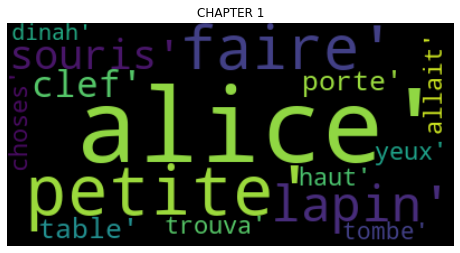

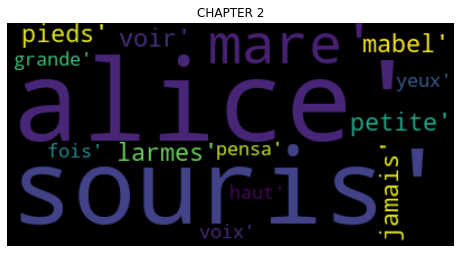

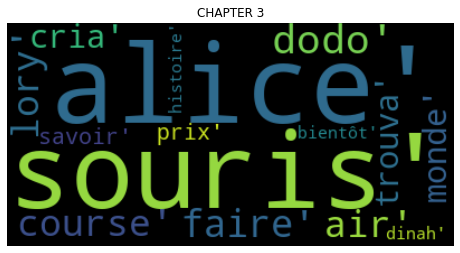

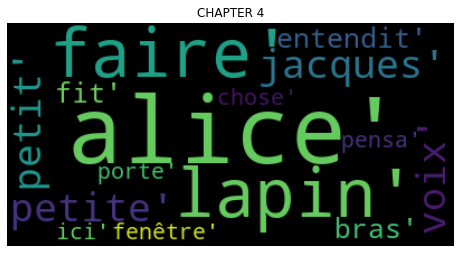

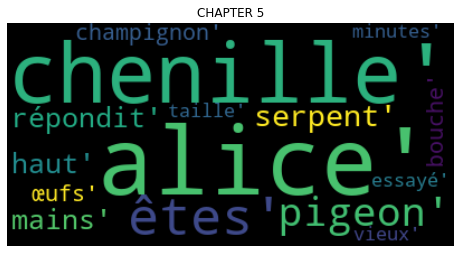

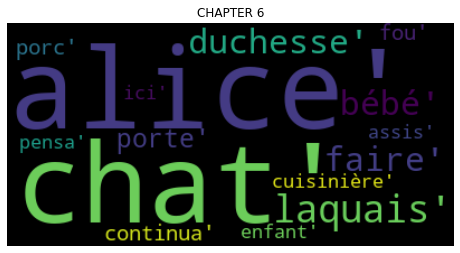

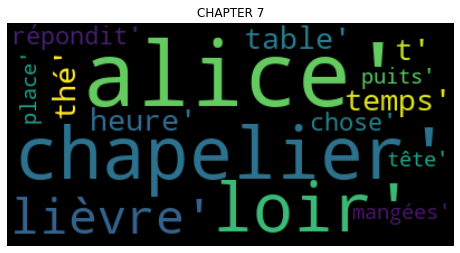

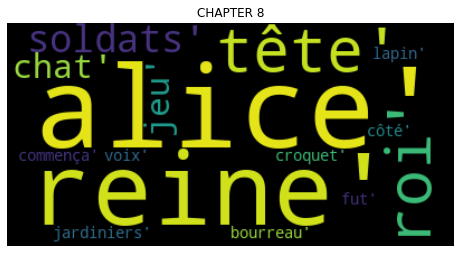

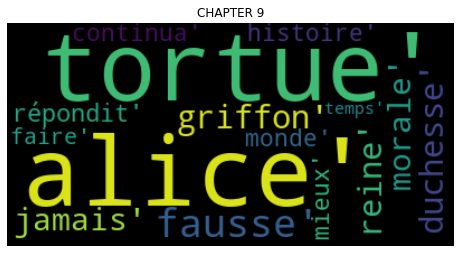

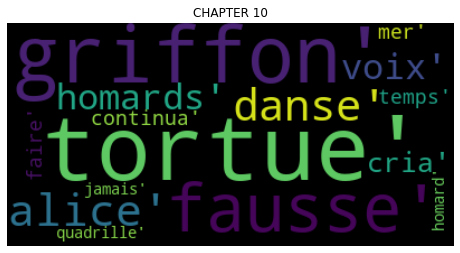

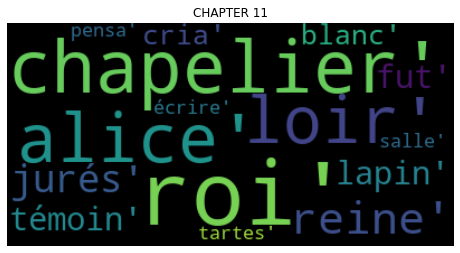

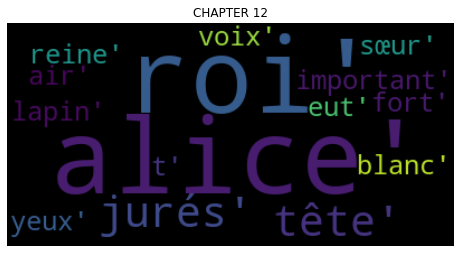

In [4]:
#get most common words
for index, chapter in enumerate(chapters):
    mydoc = nlp(chapter)

    nlp.vocab["y"].is_stop = True

    # all tokens that arent stop words or punctuations
    words = [token.text for token in mydoc if token.is_stop != True and token.is_punct != True and token.is_space != True]

    # fifteen most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(15)

    #wordbag
    listToStr = ''.join([str(elem) for elem in common_words])

    cloud = WordCloud().generate(listToStr)
    plt.figure(figsize=(8,6))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('CHAPTER '+str(index+1))


plt.show

# vectorisation

In [ ]:
list_tok_chap = []
for index, chapter in enumerate(chapters):
    mydoc = nlp(chapter)

    nlp.vocab["y"].is_stop = True

    words = [token.text for token in mydoc if token.is_stop != True and token.is_punct != True and token.is_space != True]
    
    list_tok_chap.append(words)

In [ ]:
chapters

In [5]:
final_stopwords_list = list(fr_stop)
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, stop_words=final_stopwords_list)
bags_of_words = tfidf_vectorizer.fit_transform(chapters)

In [20]:
svd = TruncatedSVD(n_components=5)
lsa = svd.fit_transform(bags_of_words)

In [21]:
topic_encoded_df = pd.DataFrame(lsa, columns = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5'])
topic_encoded_df["chapters"] = chapters
display(topic_encoded_df[['chapters', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']])

,chapters,topic_1,topic_2,topic_3,topic_4,topic_5
0,"premier. au fond du terrier. alice, assise...",0.603058,-0.189980,-0.297631,-0.035575,-0.036301
1,"ii. la mare aux larmes. ""de plus très cu...",0.577274,-0.167235,-0.434981,0.225384,-0.176336
2,iii. la course cocasse. ils formaient une ...,0.479010,-0.131193,-0.375302,0.465530,-0.236719
3,iv. l'habitation du lapin blanc. c'était l...,0.627580,-0.158574,-0.235403,-0.172908,0.007702
4,v. conseils d'une chenille. la chenille et...,0.467830,-0.014798,-0.194459,-0.274099,0.526320
5,vi. porc et poivre. alice resta une ou deu...,0.584626,-0.056616,-0.075394,-0.296215,0.224527
6,vii. un thé de fous. il y avait une table ...,0.544354,-0.209219,0.346411,0.416845,0.460200
7,viii. le croquet de la reine. un grand ros...,0.619523,-0.053008,0.183367,-0.381005,-0.222248
8,"ix. histoire de la fausse tortue. ""vous ne...",0.602562,0.663576,0.038269,0.034914,-0.003562
9,x. le quadrille de homards. la fausse tort...,0.417280,0.803092,0.030529,0.158094,0.006186


In [24]:
from sklearn.manifold import TSNE

In [27]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50,
                      learning_rate=100, n_iter=2000, verbose=1,
                      random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa)

[t-SNE] Computing 11 nearest neighbors...
[t-SNE] Indexed 12 samples in 0.000s...
[t-SNE] Computed neighbors for 12 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 12 / 12
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.525024
[t-SNE] KL divergence after 850 iterations: 0.288977
